In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import seaborn as sns

#Pour le Kmeans
from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Pour la regression lineaire:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.linear_model import LinearRegression

# Pour la regression logistique:
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('billets.csv', sep= ";")        # dataset d'entrainement
test = pd.read_csv("billets_production.csv")     # dataset de test

In [3]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
df.describe().round(2)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.00,1500.00,1500.00,1463.00,1500.00,1500.00
mean,171.96,104.03,103.92,4.49,3.15,112.68
std,0.31,0.30,0.33,0.66,0.23,0.87
min,171.04,103.14,102.82,2.98,2.27,109.49
25%,171.75,103.82,103.71,4.01,2.99,112.03
50%,171.96,104.04,103.92,4.31,3.14,112.96
75%,172.17,104.23,104.15,4.87,3.31,113.34
max,173.01,104.88,104.95,6.90,3.91,114.44


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Nous avons bien six dimensions en plus de la colonne permettant de distinguer les vrais des faux billets qui ne sera pas présente dans nos données réelles. Les types des données sont ceux attendus. Il manque des données seulement pour margin_low, il s'agit de la marge entre le bord inferieur du billet et l'image de celui-ci (en mm).

In [6]:
# Affichage des valeurs nulles s'il y en a
df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [7]:
# Identification des lignes ayant des donnees manquantes:
print(df.index[df.isnull().any(axis=1)])


Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')


Il y a des données manquantes, nous allons donc devoir faire une régression linéaire pour les combler et ne pas perdre d'informations.

# Régression linéaire

In [8]:
# Separation des donnees des donnees manquantes:
Reg_Lin_Train_df = df.dropna()
Reg_Lin_Test_df = df[df.isnull().any(axis=1)]

# Creation de X_train et Y_train:
x_train = Reg_Lin_Train_df.drop("margin_low", axis=1)
y_train = Reg_Lin_Train_df["margin_low"]

# Regression lineaire:
reg_lin = LinearRegression()
model_reg_lin = reg_lin.fit(x_train, y_train)

# Predictions:
x_train = Reg_Lin_Train_df[["is_genuine","diagonal","height_left","height_right", "margin_up", "length"]]
Reg_Lin_Train_df["margin_low_pred"] = reg_lin.predict(x_train)

In [9]:
print("Intercept:", model_reg_lin.intercept_)
print("Coéfficients:", model_reg_lin.coef_)

Intercept: 2.866822892054323
Coéfficients: [-1.14059676 -0.0130159   0.02829069  0.02674982 -0.21284432 -0.00388299]


### Verification du modèle:

In [10]:
# Instanciation:
reg_linb = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", data = df)

# Calculs:
res_lin = reg_linb.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 25 Mar 2022   Prob (F-statistic):          4.75e-299
Time:                        11:53:25   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

Prob(F-Statistic): L'hypothèse nulle du test de Fisher est que tous les coefficients sont nuls. 
Ici, elle est faible et inferieur au seuil alpha 5 % (ou 1 %), on rejet l'hypothèse nulle, notre modèle est meilleur que celui où les coefficients seraient nuls.
Le R² ajusté (puisque nous avons un grand nombre de valeurs) est satisfaisant. (superieur à 0,5).

### Test d'hypothèses par analyse des résidus:

Il y a plusieurs hypothèses à tester pour la régression linéaire :

 Normalité de la distribution des résidus : Omnibus test, l'hypothèse nulle est que les résidus sont distribués selon une loi Normale. La valeur de Prob(Omnibus) doit être proche de 1. Ici elle est nulle ce qui implique que l'hypothèse n'est pas verifée. Prob(Jacque-Bera) est redondant avec Prob(Omnibus), une valeur élevée pour le Jarque-Bera indique que les résidus sont distribués selon une loi Normale. Pour lever le doute on effectue un test d'Aderson-Darling qui nous indique que les résidus ne suivent pas une distribution Normale.
 
Homocédasticité : les variances des résidus doivent être constantes. Les tests de Breusch-Pagan et de White permettent de tester l'hypothèse d'homoscédasticité du terme d'erreur d'un modèle de régression linéaire. Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires contrairement au test de White qui est en fait un cas particulier du Breusch-Pagan. Il existe aussi le test de Goldfeld et Quandt qui n'est plus vraiment utilisé.

Non-autocorrélation : l'autocorrélation est la corrélation des erreurs (résidus) dans le temps. Durbin-Watson < 1.5, autocorrélation positive, l'hypothèse n'est pas satisfaite. 1.5 < Durbin-Watson < 2.5 pas d'autocorrélation, l'hypothèse est satisfaite. Durbin-Watson > 2.5, autocorrélation négative, l'hypothèse n'est pas satisfaite. Ici, il est de 1.888, il n'y a donc pas d'autocorrélation.

Multicollinéarité : on suppose que les prédicteurs utilisés dans la régression ne sont pas corrélés les uns aux autres. Le cond. No. est élevée il semble qu'il y ai un problème de multicollinéarité. Le VIF indique effectivement une forte multicolinéarité.

Linéarité : on fait l'hypothèse qu'il existe une relation linéaire entre les variables indépendantes et la variable dépendante. Non verifié ici.Si l'hypothèse de non-colinéarité n'est pas vérifiée, l'estimation du modèle est impossible alors que pour toutes les autres hypothèses, l'estimation est possible, mais donne un estimateur biaisé et/ou non efficace (à variance non-minimale) mais il existe des corrections possibles. La normalité des erreurs est non obligatoire, mais permet de tirer de bonnes propriétés. Elle est gardée dans ce projet parceque demandée dans l'évalutation mais elle n'est pas appropriée.

In [11]:
# La moyenne des residus est nulle:
res_lin.resid.mean()

2.4700891442365663e-13

In [12]:
# Multicollinearite:
vif= pd.Series([variance_inflation_factor(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].values, i)
               for i in range(Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].shape[1])],
              index=Reg_Lin_Train_df[["diagonal","height_left","height_right", "margin_up", "length"]].columns)
print("VIF par features:\n", vif.round(2))
print("VIF moyen:",vif.mean())

# On est oblige d'enlever ''is_genuine'' puisque c'est une variables qualitative.

VIF par features:
 diagonal        170566.67
height_left     111895.31
height_right    100858.86
margin_up          261.97
length           22708.22
dtype: float64
VIF moyen: 81258.20741161003


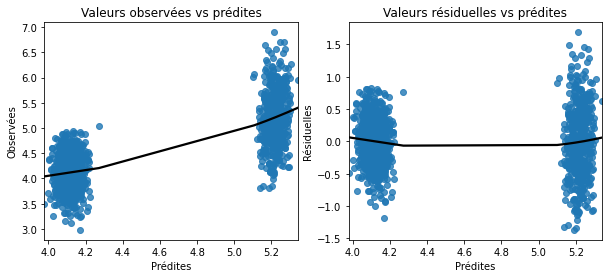

In [13]:
# Linearite:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2,figsize=(10,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'black'})
    ax[0].set_title("Valeurs observées vs prédites")
    ax[0].set(xlabel="Prédites", ylabel="Observées")

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'black'})
    ax[1].set_title("Valeurs résiduelles vs prédites")
    ax[1].set(xlabel="Prédites", ylabel="Résiduelles")
    
linearity_test(res_lin, Reg_Lin_Train_df["margin_low"])

La relation n'est pas linéaire, l'hypothèse de linéarité n'est pas vérifiée. Solutions potentielles :

Transformation non-linéaire sur les variables dépendantes/indépendantes.

Ajout d'une feature, transformation de features préexistantes (mise au carré par exemple).

Ajout de features non considérées précédemment.

La p-value du test d'Aderson-Darling vaux 3.9857722331535204e-05


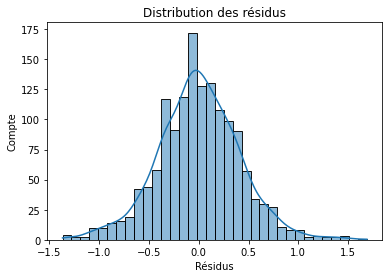

In [14]:
# Creation d'une colonne contenant les residus:
Reg_Lin_Train_df["residual"] = Reg_Lin_Train_df["margin_low"] - Reg_Lin_Train_df["margin_low_pred"]

# Normalite:
print("La p-value du test d'Aderson-Darling vaux", normal_ad(Reg_Lin_Train_df["residual"])[1])

# Graphique:
sns.histplot(Reg_Lin_Train_df["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

Une p-value inférieure à alpha pour le test d'Anderson-Darling indique que l'hypothèse nulle de normalité de la distribution des résidus est rejetée. Ici, l'hypothèse est rejetée puisque la p-value obtenue est inférieure au seuil alpha 5 % (ou 1 %), les résidus suivent pas une distribution Normale.

{'Test Statistic': 185.4402476041065, 'p-value': 5.215881958837578e-26, 'F-Statistic': 8.016852051194936, 'F-Test p-value': 4.616518789499411e-28}


Text(0.5, 1.0, 'Homoscédasticité')

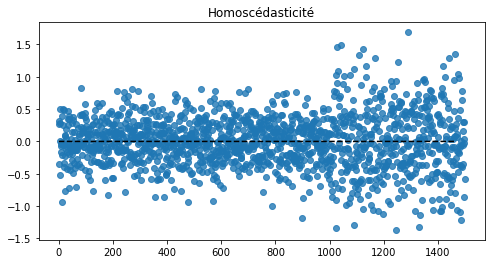

In [15]:
# Homoscedasticite:
white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

# Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=Reg_Lin_Train_df.index, y=Reg_Lin_Train_df["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(Reg_Lin_Train_df.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

La répartition semble aléatoire sur le graphique. L'hypothèse nulle du test de White est qu'il y a homoscédasticité (les résidus sont dispersés aléatoirement, la variance d'un individu à un autre est constante), l'hypothèse alternative est qu'il y a hétéroscédasticité. On fixe un seuil alpha de 5 % (ou 1 % dans les deux cas ok, mais plus restrictif, voir selon le taux d'erreur acceptable non précisé dans le cahier des charges). La p-value est ici très inférieure au seuil, on peut rejeter l'hypothèse nulle d'homoscédasticité. L'hypothèse d'homoscédasticité de notre régression linéaire est donc considérée comme non vérifiée au risque alpha 5 % (ou 1 %).

,margin_low,dfb_Intercept,dfb_is_genuine[T.True],dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.52,-0.046,0.047,-0.021,0.062,0.078,-0.020,-0.019,0.002,0.759,0.020,0.109,0.759,0.109
1,3.77,-0.052,-0.002,0.035,0.044,0.007,0.006,0.006,0.001,-0.843,0.006,-0.066,-0.843,-0.066
2,4.40,-0.032,-0.001,0.038,0.031,-0.022,-0.012,-0.000,0.000,0.640,0.008,0.059,0.639,0.058
3,3.62,-0.036,-0.003,0.068,0.001,-0.018,0.006,-0.020,0.001,-1.252,0.004,-0.084,-1.253,-0.084
4,4.04,0.001,0.001,-0.001,0.001,-0.001,0.001,-0.001,0.000,0.022,0.009,0.002,0.022,0.002


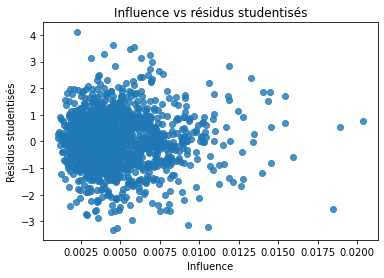

In [16]:
# Identification des individus atypiques et influents (iai), preambulle:
student_resid = res_lin.get_influence().resid_studentized_external
(cooks, p_val_cooks) = res_lin.get_influence().cooks_distance
(dffits, p_val_dffits) = res_lin.get_influence().dffits
leverage = res_lin.get_influence().hat_matrix_diag

# Graphique:
sns.regplot(leverage, res_lin.resid_pearson, fit_reg=False)
plt.title("Influence vs résidus studentisés")
plt.xlabel("Influence")
plt.ylabel("Résidus studentisés")

# Creation d'un dataframe de travail:
iai_df = pd.concat([Reg_Lin_Train_df["margin_low"], res_lin.get_influence().summary_frame()], axis = 1)
iai_df = iai_df.rename(columns={"hat_diag": "leverage"})       #hat_diag = leverage donc on change le nom
iai_df.round(3).head()

influence.resid_studentized_external : résidus studentisés en externe, permettent de détecter les valeurs aberrantes, observations qui possèdent des valeurs extrêmes sur l'ensemble des prédicteurs ou la variable dépendante.

influence.cooks_distance : distance de Cook, utilisée pour estimer l'influence d'une donnée lors de l'utilisation de méthodes des moindres carrés.

influence.dffits : DFFITS statistics ("difference in fit(s)"), c'est une méthode de diagnostique de l'influence d'un point dans une régression.

influence.hat_matrix_diag : la diagonale de projection, ou "hat". La mtatrice hat décrit l'influence de chaque valeur dépendante sur chaque valeur estimée. Sa diagonale correspond aux 'leverages', qui décrivent l'influence de chaque valeur sur l'estimation pour la même observation.


In [17]:
# Studentisation des residus:
std_res = iai_df.student_resid
print ("résidus studentisés:\n", std_res.describe().round(2))

# Individus atypiques:
outlier = pd.DataFrame((iai_df["margin_low"][abs(std_res) > 2]))
print(outlier.count())

résidus studentisés:
 count    1463.00
mean        0.00
std         1.00
min        -3.34
25%        -0.63
50%        -0.02
75%         0.62
max         4.13
Name: student_resid, dtype: float64
margin_low    78
dtype: int64


Nous trouvons donc 78 individus atypiques (résidus studentisés > 2 en valeur absolue), dans les faits, on ne supprime les outliers que s'ils sont influents. Les points a forte influence sont qui se placent au-dessus du seuil (2*k) +2/n avec k = nombre de variables explicatives et n = nombre d'observations.

In [18]:
# Identification des individus a forte influence:
k_reg_lin = 5                                       # k = nombre de variables predictives pour la regression lineaire +1 si on a une constante
n_reg_lin = 1500                                    # n = nombre d'observations
lev_thr = ((2*k_reg_lin)+2)/n_reg_lin               #=0.047 Seuil (threshold), toutes valeurs au dessus aura une forte influence

print(iai_df["leverage"].describe().round(3))

hg_leverage = iai_df["margin_low"][abs(iai_df["leverage"]) > lev_thr]
print("nombre d'individus à forte influence:", hg_leverage.count())

count    1463.000
mean        0.005
std         0.002
min         0.001
25%         0.003
50%         0.004
75%         0.006
max         0.020
Name: leverage, dtype: float64
nombre d'individus à forte influence: 133


Il y a donc 133 individus influents. Il faut maintenant recouper les individus atypiques et influents pour identifier les individus ayant un impact sur la régression linéaire

In [19]:
# Identification des individus atypiques a forte influence:
outliers_hg_lev =pd.merge(outlier,hg_leverage, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print(outliers_hg_lev)

margin_low_x    10
margin_low_y    10
dtype: int64
      margin_low_x  margin_low_y
1024          4.24          4.24
1029          6.01          6.01
1074          4.36          4.36
1089          3.86          3.86
1122          4.15          4.15
1134          6.34          6.34
1223          4.20          4.20
1329          3.82          3.82
1412          4.14          4.14
1478          6.08          6.08


Il y a au final 10 individus à la fois influents et atypiques. On supprime les individus influents et on relance la régression linéaire.

In [20]:
# Suppression des iai:
df_sans_iai = df.drop(outliers_hg_lev.index)

# Instanciation:
reg_lin_c = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", data = df_sans_iai)

# Calculs:
model_reg_lin_b = reg_lin_c.fit()
print(model_reg_lin_b.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     408.7
Date:                Fri, 25 Mar 2022   Prob (F-statistic):          4.38e-307
Time:                        11:53:29   Log-Likelihood:                -739.56
No. Observations:                1453   AIC:                             1493.
Df Residuals:                    1446   BIC:                             1530.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8646      8

Le R² (ajusté ou non) augmente légèrement (0.61 à 0.62).

La F-stat passe de 390.7 à 408.7 avec un changement d'ordre de grandeur de la Prob de -299 à -307.

L'AIC passe de 1562 à 1493.

Le BIC de 1599 à 1530.

Le log diminue de -774.14 à -739.56

Les coefficients et leurs statistiques restent eux globalement inchangés.

Le nombre d'individus influents et atypiques est faible (10/1463), ils n'influencent finalement pas tant le jeu de données et leur suppression n'apporte pas beaucoup au modèle, la décision est prise de continuer avec eux tout en gardant leur présence à l'esprit. Il est toujours possible d'utiliser, si nécessaire, df_sans_iai à la place de df.

### Application du modèle

In [21]:
# Application du modele sur les donnees test
x_test = Reg_Lin_Test_df[["is_genuine","diagonal","height_left","height_right", "margin_up","length"]]
Reg_Lin_Test_df["margin_low"] = reg_lin.predict(x_test)

# Concatenation:
reg_lin_result = [Reg_Lin_Test_df, Reg_Lin_Train_df]
df = pd.concat(reg_lin_result)
df = df.drop(["margin_low_pred", "residual"], axis=1)
#df.info()
df.describe().round(3)

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1500.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.483,3.151,112.679
std,0.305,0.299,0.326,0.660,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.028,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


Il n'y a plus de valeurs manquantes et très peu de changement au niveau général (pour margin_low le premier quartile passe de 4.015 à 4.028).

In [22]:
df.head(1500)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.064954,3.25,112.79
99,True,171.93,104.07,104.18,4.111990,3.14,113.08
151,True,172.07,103.80,104.38,4.134003,3.02,112.93
197,True,171.45,103.66,103.80,3.993571,3.62,113.27
241,True,171.83,104.14,104.06,4.140399,3.02,112.36
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.420000,3.09,111.28
1496,False,172.19,104.63,104.44,5.270000,3.37,110.97
1497,False,171.80,104.01,104.12,5.510000,3.36,111.95
1498,False,172.06,104.28,104.06,5.170000,3.46,112.25


In [23]:
# visualisation variable is_genuine
df['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

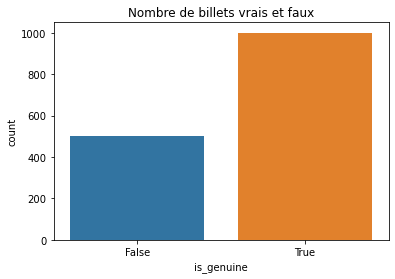

In [24]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
plt.show()

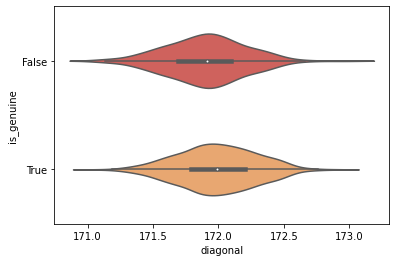

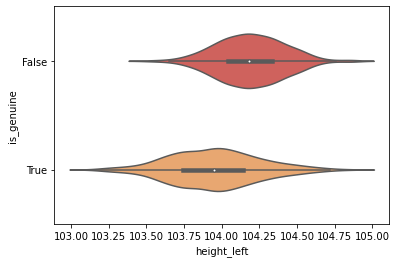

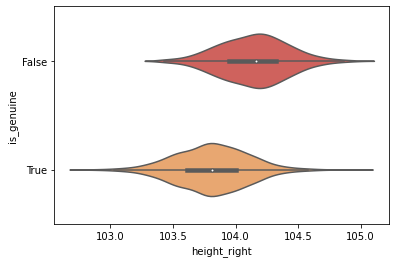

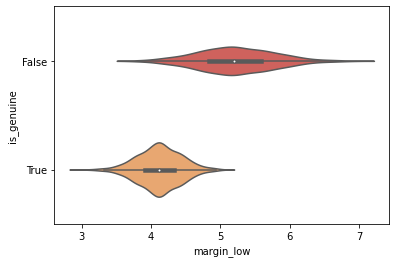

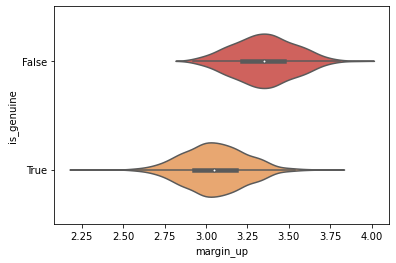

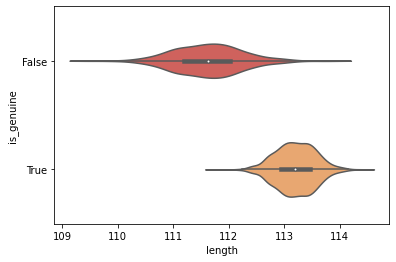

In [25]:
# Comparaison entre les vrais et faux billets (violinplot)
sns.set_palette('Spectral')
medianprops = dict(linewidth=2, color='.2')
meanprops={"marker":"o","markerfacecolor":"yellow", "markeredgecolor":"yellow","markersize":"5"}

for variable in df.columns[1:7]:
    sns_plot=sns.violinplot(
        x = df[variable], 
        y = df.is_genuine,
        orient = "h",
        medianprops = medianprops, showmeans=True, meanprops=meanprops,width = .5)
    plt.show()

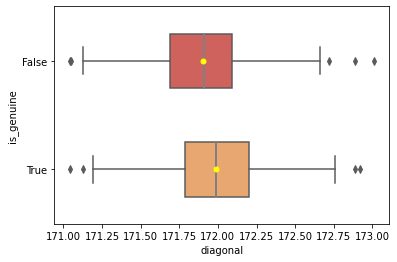

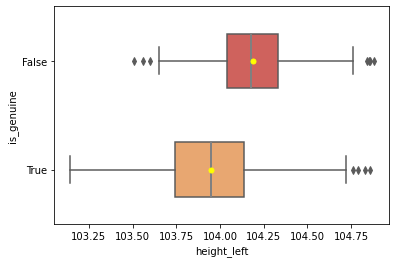

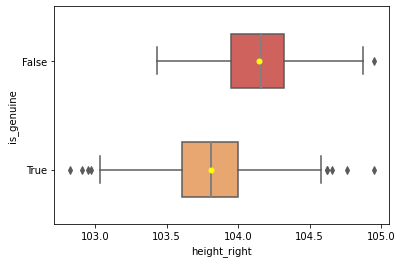

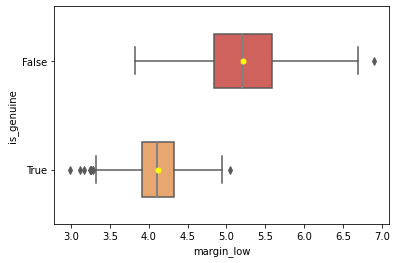

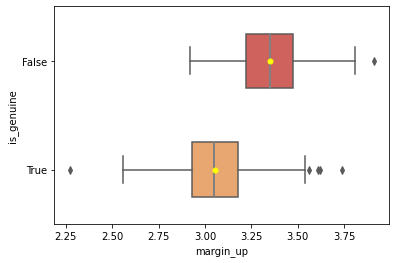

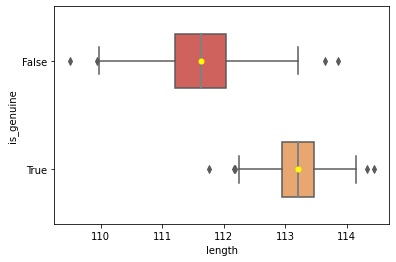

In [26]:
# Comparaison entre les dimensions des vrais et faux billets (boxplot)
medianprops = dict(linewidth=2, color='grey')
meanprops={"marker":"o","markerfacecolor":"yellow", "markeredgecolor":"yellow","markersize":"5"}

for variable in df.columns[1:7]:
    sns_plot=sns.boxplot(
        x = df[variable], 
        y = df.is_genuine,
        orient = "h",
        medianprops = medianprops, showmeans=True, meanprops=meanprops,width = .5)
    plt.show()

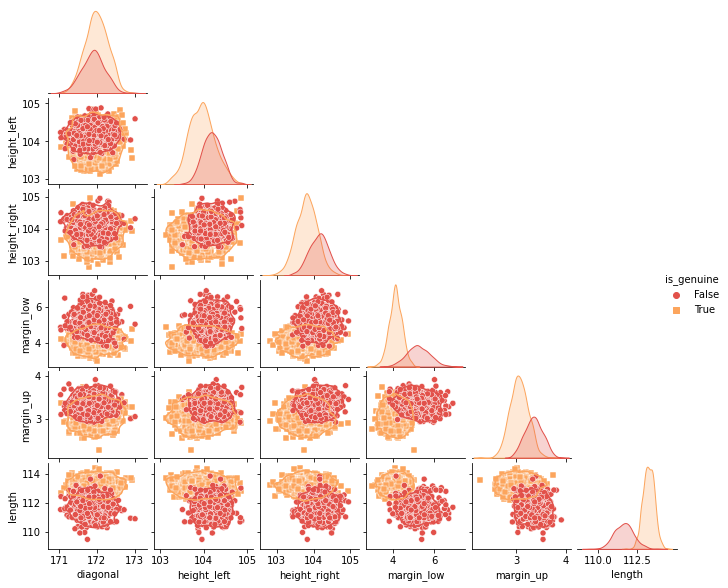

In [27]:

g = sns.pairplot(df, hue='is_genuine', markers=['o','s'], corner=True)
g.fig.set_size_inches(10,8)
g.map_lower(sns.kdeplot, levels=2, color='.2')
plt.show()

Certains points paraissent particulièrement éloignés de leurs groupes, nous allons donc essayer d'identifier les outliers dans notre jeu de données. 
Les dimensions qui permettent vraiment de distinguer les vrais des faux billes sont length et margin_low. (cf densités sur la diagonale qui ne se recouvrent que très peut). 

On retient donc ces variables comme meilleures candidates, mais on garde toutes les variables pour les analyses suivantes pour avoir une approche plus naïve des algorithmes. 
Dans un projet sans cahier des charges, la création de fonctions de classification reposant sur length et margin_low serai suffisante pour différencier les vrais des faux billets. 
On remarque également que la sortie de ce graphique peut être un peu longue pour finalement assez peu de données (moins de 1500), c'est un problème pour l'optimisation.

In [28]:
matrix = df.corr()
matrix.round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.00,0.13,-0.38,-0.49,-0.79,-0.61,0.85
diagonal,0.13,1.00,0.02,-0.02,-0.11,-0.06,0.10
height_left,-0.38,0.02,1.00,0.24,0.31,0.25,-0.32
height_right,-0.49,-0.02,0.24,1.00,0.39,0.31,-0.40
margin_low,-0.79,-0.11,0.31,0.39,1.00,0.43,-0.67
margin_up,-0.61,-0.06,0.25,0.31,0.43,1.00,-0.52
length,0.85,0.10,-0.32,-0.40,-0.67,-0.52,1.00


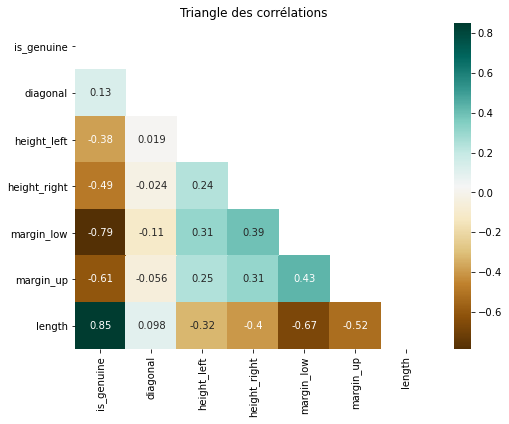

In [29]:
mask = np.triu(np.ones_like(matrix, dtype=np.bool))
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, mask=mask, annot=True, cmap='BrBG')
plt.title('Triangle des corrélations')
plt.show()

In [30]:
description = df.groupby('is_genuine').describe().round(2).T
description

is_genuine           False    True 
diagonal     count  500.00  1000.00
             mean   171.90   171.99
             std      0.31     0.30
             min    171.04   171.04
             25%    171.69   171.79
             50%    171.91   171.99
             75%    172.09   172.20
             max    173.01   172.92
height_left  count  500.00  1000.00
             mean   104.19   103.95
             std      0.22     0.30
             min    103.51   103.14
             25%    104.04   103.74
             50%    104.18   103.95
             75%    104.33   104.14
             max    104.88   104.86
height_right count  500.00  1000.00
             mean   104.14   103.81
             std      0.27     0.29
             min    103.43   102.82
             25%    103.95   103.61
             50%    104.16   103.81
             75%    104.32   104.00
             max    104.95   104.95
margin_low   count  500.00  1000.00
             mean     5.22     4.12
             std      0.55     0.31
             min      3.82     2.98
             25%      4.84     3.91
             50%      5.20     4.11
             75%      5.59     4.33
             max      6.90     5.04
margin_up    count  500.00  1000.00
             mean     3.35     3.05
             std      0.18     0.19
             min      2.92     2.27
             25%      3.22     2.93
             50%      3.35     3.05
             75%      3.47     3.18
             max      3.91     3.74
length       count  500.00  1000.00
             mean   111.63   113.20
             std      0.62     0.36
             min    109.49   111.76
             25%    111.20   112.95
             50%    111.63   113.20
             75%    112.03   113.46
             max    113.85   114.44

# Regression logistique:

Nous cherchons à mettre en place un modèle prédictif à l'aide de données annotées, le but étant d'expliquer une variable qualitative binaire (Vrai/faux) par des variables aléatoires quantitatives (mesures en millimètre), il faut donc faire une régression logistique. On commence par isoler la variable cible des autres.

In [31]:
# y (authenticite): 
y_billet = df.loc[:, df.columns == "is_genuine"]
print(y_billet.value_counts())                                  #Comptage des modalites de y

# X (les autres):
X_billet = df.loc[:, df.columns != "is_genuine"]
X_billet = sm.tools.add_constant(X_billet)                      #Il faut ajouter une constante dans Statsmodels
print(X_billet.head())

is_genuine
True          1000
False          500
dtype: int64
     const  diagonal  height_left  height_right  margin_low  margin_up  length
72     1.0    171.94       103.89        103.45    4.064954       3.25  112.79
99     1.0    171.93       104.07        104.18    4.111990       3.14  113.08
151    1.0    172.07       103.80        104.38    4.134003       3.02  112.93
197    1.0    171.45       103.66        103.80    3.993571       3.62  113.27
241    1.0    171.83       104.14        104.06    4.140399       3.02  112.36


In [32]:
# Regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Calculs:
res_log = reg_log.fit()

# Resume des resultats:
print(res_log.summary())

Optimization terminated successfully.
         Current function value: 0.026349
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1493
Method:                           MLE   Df Model:                            6
Date:                Fri, 25 Mar 2022   Pseudo R-squ.:                  0.9586
Time:                        11:53:46   Log-Likelihood:                -39.524
converged:                       True   LL-Null:                       -954.77
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -230.4143    249.954     -0.922      0.357    -720.316     259.487
diagonal         0.256

L'algorithme de Newton-Raphson est utilisé par défaut.

13 itérations ont été nécessaires pour maximiser la log-vraisemblance.

Le warning est dû au fait que le modèle apprend "trop bien", il y a des variables qui prédisent parfaitement y, ce n'est pas réaliste, cela vient du fait que nos données sont très artificielles, il y a donc peu d'erreur.

Il y a des variables x non-significatives au seuil alpha 5 % (si on prend alpha 1 %, on enlèvera height_right en plus), on recommence la régression sans ces variables (diagonal, height_left).

In [33]:
# On ne garde que les variables significatives a alpha = 5% dans X_Billet:
X_billet = df[["height_right", "margin_low", "margin_up", "length"]]
X_billet = sm.add_constant(X_billet)

# On recommence la regression logistique:
reg_log = Logit(endog=y_billet,exog=X_billet)

# Creation du modele:
model_reg_log = reg_log.fit()

# Resume des resultats:
print(model_reg_log.summary2())

Optimization terminated successfully.
         Current function value: 0.026815
         Iterations 13
                         Results: Logit
Model:                Logit            Pseudo R-squared: 0.958   
Dependent Variable:   is_genuine       AIC:              90.4453 
Date:                 2022-03-25 11:53 BIC:              117.0114
No. Observations:     1500             Log-Likelihood:   -40.223 
Df Model:             4                LL-Null:          -954.77 
Df Residuals:         1495             LLR p-value:      0.0000  
Converged:            1.0000           Scale:            1.0000  
No. Iterations:       13.0000                                    
-----------------------------------------------------------------
               Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
const        -285.3339 139.1600 -2.0504 0.0403 -558.0825 -12.5852
height_right   -3.3223   1.1166 -2.9752 0.0029   -5.5109  -1.1337

LLR p-value est inférieure à 0.05, le modèle est significatif dans son ensemble.
Le pseudo R² est très proche de 1, notre modèle explique donc la majorité de la variance observée.

# Application du modèle:

In [34]:
# Application du modele sur les donnees training:
df["proba"] = model_reg_log.predict(X_billet)
df["y_pred"] = (model_reg_log.predict(X_billet) >= 0.5).astype(int)
df.head().round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.94,103.89,103.45,4.06,3.25,112.79,1.00,1
99,True,171.93,104.07,104.18,4.11,3.14,113.08,1.00,1
151,True,172.07,103.80,104.38,4.13,3.02,112.93,1.00,1
197,True,171.45,103.66,103.80,3.99,3.62,113.27,0.99,1
241,True,171.83,104.14,104.06,4.14,3.02,112.36,0.96,1


# Evaluation du modèle:

[[32.8         0.53333333]
 [ 0.2        66.46666667]]


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique')

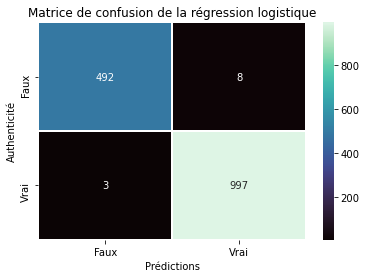

In [35]:
# Matrice de confusion:
n_reg_lin = 1500
conf_matrix_reg_log = model_reg_log.pred_table()
prct = (conf_matrix_reg_log*100)/n_reg_lin
print(prct)

# Graphique:
sns.heatmap(conf_matrix_reg_log,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique")

In [36]:
print("Précision:",accuracy_score(df["is_genuine"], df["y_pred"]))
print("Spécificité:",precision_score(df["is_genuine"], df["y_pred"]))
print("Sensibilité:",recall_score(df["is_genuine"], df["y_pred"]))
print("Score F1:",recall_score(df["is_genuine"], df["y_pred"]))

Précision: 0.9926666666666667
Spécificité: 0.9920398009950249
Sensibilité: 0.997
Score F1: 0.997


Notre modèle est quasiment parfait puisque tous les scores s'approchent de 1. Ce n'est pas très réaliste, mais cela prouve qu'il fonctionne.

Accuracy : (précision) ratio de prédictions justes. C'est une bonne mesure si le jeu de données est symétrique et si les faux positifs et faux négatifs ont la même importance/le même poid. Accuracy = TP+TN/total

Precision : (spécificité) ratio de vrais positifs sur le total des prédictions positives. Precision = TP/TP+FP

Recall : (sensibilité) - Le ratio de positif prédit correctement parmi tous les positifs. Recall = TP/TP+FN

F1 score - c'est une moyenne pondérée de la sensibilité et de la spécificité. On prend donc en compte les faux positifs et les faux négatifs en compte. Ce score, bien que moins intuitif que la précision est plus juste en particuliers pour les jeux de données dissymétriques. F1 Score = 2(Recall Precision) / (Recall + Precision)

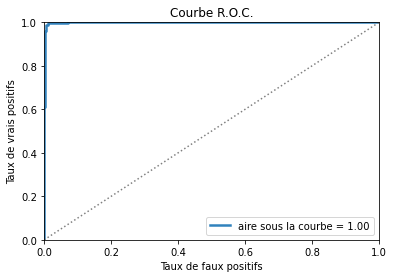

In [37]:
# Courbe R.O.C.:
fpr, tpr, _ = roc_curve(df["is_genuine"],df["proba"])
roc_auc = roc_auc_score(df["is_genuine"],df["proba"])

# Graphique:
plt.title("Courbe R.O.C.")
plt.plot(fpr,
        tpr,
        color="#3182bd",
        linewidth=2.5,
        label="aire sous la courbe = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1],color="grey", linestyle=":")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = "lower right")
plt.ylabel("Taux de vrais positifs")
plt.xlabel("Taux de faux positifs")
plt.show()

Comme avec les metrics calculées plus haut, on retombe sur un modèle quasiment parfait avec une aire sous la courbe approximée à 1.

# Application du modèle aux données test:

In [38]:

# Prediction sur des donnes inconnues:
X_test = test[["height_right","margin_low","margin_up","length"]]
X_test = sm.add_constant(X_test)
test["Probabilité vrai billet"] = model_reg_log.predict(X_test)
test["Probabilité vrai billet"] = test["Probabilité vrai billet"]*100
test["Probabilité vrai billet"] = round(test["Probabilité vrai billet"],2)
test["Probabilité vrai billet"] = test["Probabilité vrai billet"].astype(str)+'%'
test["Prédiction"] = (model_reg_log.predict(X_test) >= 0.5).astype(int)
print(test[["id","Probabilité vrai billet","Prédiction"]])

# Affichage des resultats:
print("\n\nIdentification des billets:")
for i, k in zip(test["Prédiction"],test["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

    id Probabilité vrai billet  Prédiction
0  A_1                    0.0%           0
1  A_2                    0.0%           0
2  A_3                    0.0%           0
3  A_4                  99.62%           1
4  A_5                  100.0%           1


Identification des billets:
Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


Il y a donc une prédiction de trois billets faux (0) et de deux vrais (1).

# K-Means:

Nous passons l'étape de détermination du nombre de clusters optimal puisque nous cherchons ici à en avoir 2 (vrai et faux).

In [39]:
df.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,proba,y_pred
72,True,171.94,103.89,103.45,4.064954,3.25,112.79,0.997694,1
99,True,171.93,104.07,104.18,4.111990,3.14,113.08,0.998127,1
151,True,172.07,103.80,104.38,4.134003,3.02,112.93,0.996980,1
197,True,171.45,103.66,103.80,3.993571,3.62,113.27,0.988619,1
241,True,171.83,104.14,104.06,4.140399,3.02,112.36,0.964849,1


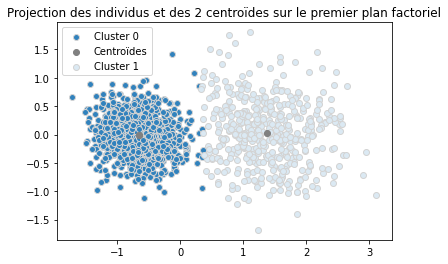

is_genuine  False  True 
row_0                   
0              19    998
1             481      2


In [40]:
# Nombre de clusters:
n_clust = 2

# Clustering par K-means:
km = KMeans(n_clusters=n_clust,random_state=1994)
x_km = km.fit_transform(df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

# Ajout d'une colonne contenant le cluster attribue:
clusters_km = km.labels_
#df["cluster_km"] = km.labels_
#df["cluster_km"] = df["cluster_km"].apply(str)

centroids_km = km.cluster_centers_

# Clustering par projection des individus sur le premier plan factoriel:
pca_km = decomposition.PCA(n_components=3).fit(df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])
acp_km = PCA(n_components=3).fit_transform(df[["diagonal","height_left","height_right","margin_low","margin_up","length"]])

centroids_km_projected = pca_km.transform(centroids_km)

# Graphique:
for couleur,k in zip(["#3182bd","#dbe9f3"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des individus et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)))
plt.show()

#Verrfication de la classification: Matrice de confusion:
km_matrix = pd.crosstab(clusters_km,df["is_genuine"])
print(km_matrix)

Text(0.5, 1.0, 'Matrice de confusion K-means\n')

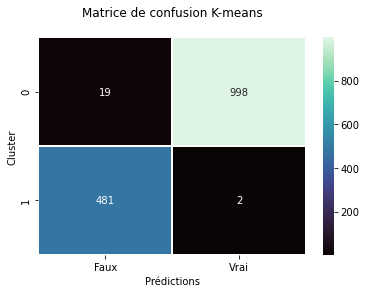

In [41]:
# Graphique:
sns.heatmap(km_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["0","1"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Cluster")
plt.title("Matrice de confusion K-means\n")

Comme attendu, notre classification n'est pas parfaite, globalement le premier cluster semble plus correspondre aux faux billets pendant que le second correspond plus au vrai.

In [42]:
# Predictions sur des donnees inconnues:
x_test_km = test[["diagonal","height_left","height_right","margin_low","margin_up","length"]]

test["cluster_pred"] = km.predict(x_test_km)
print(test[["id","cluster_pred"]])

    id  cluster_pred
0  A_1             1
1  A_2             1
2  A_3             1
3  A_4             0
4  A_5             0


On obtient la même classification qu'avec la régression logistique.

In [43]:
# On supprime les colonnes devenues inutiles:
df = df.drop(["proba", "y_pred"], axis=1)

# Sauvegarde fichier df complet si necessaire:
#df.to_csv("billets_complet.csv", index=False)

# On essaye d'autre modèles

## K plus proches voisins

In [44]:
from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier

#on stock les données explicatives dans la variable data
data = df.iloc[:,1:7]
#on stock la variable cible 'charges_classes' dans la variable target
target = df['is_genuine']

#on separe les données en un ensemble d'apprentissage et un ensemble de test(33%)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33) 

#on centre et reduit les variables explicatives des deux echantillons
X_train_scaled = preprocessing.scale(X_train)
y_train_scaled = preprocessing.scale(y_train)

In [45]:
score = []


for k in range(2, 50):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score.append(knn.score(X_test, y_test)) 

#on affiche les scores
print(score)

#le meilleur score est le 1 avec 0,99%  
#(Ce score varie quand on relance le notebook vu que l'ensemble de test est fait sur 33% des données)

[0.9919191919191919, 0.9919191919191919, 0.98989898989899, 0.9919191919191919, 0.9919191919191919, 0.9919191919191919, 0.9919191919191919, 0.9919191919191919, 0.9919191919191919, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899, 0.98989898989899]


In [46]:
#Création du classificateur et entraînement du modèle
knn_m = neighbors.KNeighborsClassifier(n_neighbors=2)
knn_m.fit(X_train, y_train)

#On applique le modèle aux données de l'ensemble de test et stocker les prédictions obtenues dans la variable y_pred.
y_pred = knn.predict(X_test)

#On affiche une matrice de confusion pour comparer les classes réelles et prédites.
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,False,True
Classe réelle,,
False,171,5
True,0,319


In [47]:
#Score du modèle 
score = knn_m.score(X_test, y_test)
score

0.9919191919191919

## SVM

In [48]:
#on ajuste X_train
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
#on applique la meme transformation à X_test
X_test_scaled = scaler.transform(X_test)


#On crée un classifieur clf
clf = svm.SVC(gamma=0.01,  kernel='rbf')

#On entraine l'algorithme sur l'ensemble d'entraînement (X_train_scaled et y_train).
clf.fit(X_train_scaled, y_train)

#On crée un dictionnaire parametres contenant les valeurs possibles prises pour le paramètre
parametres = {'C':[0.1,1,10,50], 'kernel':['rbf','linear']}  

#On applique la fonction model_selection.GridSearchCV() au modèle clf
grid_clf = model_selection.GridSearchCV(estimator=clf, param_grid=parametres)

#On entraîne grid_clf sur l'ensemble d'entraînement, (X_train_scaled, y_train) 
#ET on sauvegarde les résultats dans l'objet grille.

grille = grid_clf.fit(X_train_scaled,y_train)

#on affiche toutes les combinaisons possibles d'hyperparamètres 
#et la performance moyenne du modèle associé par validation croisée.
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])

#on affiche la meilleur combinaison
print('\n''le meilleur paramètre est:',(grid_clf.best_params_))

                           params  mean_test_score
0     {'C': 0.1, 'kernel': 'rbf'}         0.986070
1  {'C': 0.1, 'kernel': 'linear'}         0.991045
2       {'C': 1, 'kernel': 'rbf'}         0.989055
3    {'C': 1, 'kernel': 'linear'}         0.991045
4      {'C': 10, 'kernel': 'rbf'}         0.991045
5   {'C': 10, 'kernel': 'linear'}         0.991045
6      {'C': 50, 'kernel': 'rbf'}         0.992040
7   {'C': 50, 'kernel': 'linear'}         0.991045

le meilleur paramètre est: {'C': 50, 'kernel': 'rbf'}


In [49]:
#Prédiction des features test et création de la matrice de confusion
y_pred = grid_clf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

#Les resultats obtenu sont légèrement moins bon

Classe prédite,False,True
Classe réelle,,
False,172,4
True,0,319


In [50]:
#on affiche le score obtenu avec ce modele
print("score:",grid_clf.score(X_test_scaled,y_test))

#Le score obtenu est légèrement moins bon que le précedent
#(Ce score varie quand on relance le notebook vu que l'ensemble de test est fait sur 33% des données)

score: 0.9838383838383838


## Random Forest

In [51]:
# Création du classificateur et construction du modèle sur les données d'entraînement
clf_rf = ensemble.RandomForestClassifier() 

#On entraine l'algorithme sur l'ensemble d'entraînement (X_train_scaled et y_train).
clf_rf.fit(X_train_scaled, y_train)

#On crée un dictionnaire parametres contenant les valeurs possibles prises pour le paramètre
params_rf=[{'min_samples_split': [(i) for i in range (2,30,2)], 
                 'max_features': ['sqrt', 'log2']}]

#On applique la fonction model_selection.GridSearchCV() au modèle clf
grid_clf_rf = model_selection.GridSearchCV(estimator=clf_rf, param_grid=params_rf)

#On entraîne grid_clf sur l'ensemble d'entraînement, (X_train_scaled, y_train) 
#ET on sauvegarde les résultats dans l'objet grille.

grille_rf = grid_clf_rf.fit(X_train_scaled,y_train)

#on affiche toutes les combinaisons possibles d'hyperparamètres 
#et la performance moyenne du modèle associé par validation croisée.
print(pd.DataFrame.from_dict(grille_rf.cv_results_).loc[:,['params', 'mean_test_score']])

#on affiche la meilleur combinaison
print('\n''le meilleur paramètre est:',(grid_clf_rf.best_params_))

                                               params  mean_test_score
0    {'max_features': 'sqrt', 'min_samples_split': 2}         0.990050
1    {'max_features': 'sqrt', 'min_samples_split': 4}         0.992040
2    {'max_features': 'sqrt', 'min_samples_split': 6}         0.991045
3    {'max_features': 'sqrt', 'min_samples_split': 8}         0.992040
4   {'max_features': 'sqrt', 'min_samples_split': 10}         0.992040
5   {'max_features': 'sqrt', 'min_samples_split': 12}         0.992040
6   {'max_features': 'sqrt', 'min_samples_split': 14}         0.992040
7   {'max_features': 'sqrt', 'min_samples_split': 16}         0.992040
8   {'max_features': 'sqrt', 'min_samples_split': 18}         0.991045
9   {'max_features': 'sqrt', 'min_samples_split': 20}         0.992040
10  {'max_features': 'sqrt', 'min_samples_split': 22}         0.991045
11  {'max_features': 'sqrt', 'min_samples_split': 24}         0.991045
12  {'max_features': 'sqrt', 'min_samples_split': 26}         0.991045
13  {'

In [52]:
#Prédiction des features test et création de la matrice de confusion
y_pred = grid_clf_rf.predict(X_test_scaled)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,False,True
Classe réelle,,
False,176,4
True,1,314


In [53]:
#on affiche le score obtenu avec ce modèle
print("score:",grid_clf_rf.score(X_test_scaled,y_test))

#Le score obtenu est entre les deux autre test
#(Ce score varie quand on relance le notebook vu que l'ensemble de test est fait sur 33% des données)

score: 0.98989898989899
